In [110]:
import os
from collections import OrderedDict
import numpy as np
import pandas
import matplotlib.pyplot as plt
import skimage.measure
from scipy.stats import percentileofscore
from example.cbnu.utils import get_interval
%matplotlib inline

## Helper functions

In [2]:
def remove_nan(array):
    return array[~np.isnan(array)]

## Parameter settings

In [3]:
input_path = 'C:\\Users\\user\\Documents\\Bodo_Rueckauer\\Data\\direction_selectivity'
times_filename = '자극시점.xlsx'

## Load data

In [4]:
times_filepath = os.path.join(input_path, times_filename)
output_path = os.path.join(input_path, 'output')
if not os.path.exists(output_path):
    os.makedirs(output_path)

label_map = {'Moving_R>L': 0, 'Moving_RT>LB': 1, 'Moving_T>B': 2,  
             'Moving_LT>RB': 3, 'Moving_L>R': 4, 'Moving_LB>RT': 5, 
             'Moving_B>T': 6, 'Moving_RB>LT': 7}

num_directions = len(label_map)
num_trials = 3  # None

angles = 2 * np.pi * np.arange(num_directions) / num_directions

In [5]:
trigger_sheet = pandas.read_excel(times_filepath, sheet_name=0, header=1, 
                                  skiprows=1, nrows=num_trials,
                                  usecols=2+np.arange(num_directions))

In [6]:
trigger_times = trigger_sheet.values

if num_trials is None:
    num_trials = trigger_times.shape[1]

all_trigger_times = np.ravel(trigger_times)
trigger_durations = np.diff(all_trigger_times)
# Add a trigger duration for final trigger.
trigger_durations = np.concatenate([trigger_durations, 
                                    [np.median(trigger_durations)]])

spike_sheet = pandas.read_excel(times_filepath, sheet_name=1, header=0)

spike_times_cells = OrderedDict()
for cell_name, cell_data in spike_sheet.items():
    if 'ch_' not in cell_name:
        continue
    spike_times_cells[cell_name] = remove_nan(cell_data.to_numpy())

In [64]:
def snr(data):
    return np.var(np.mean(data, 0), -1) / np.mean(np.var(data, -1), 0)

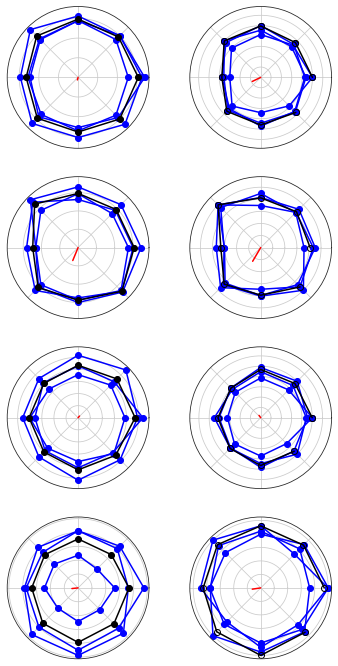

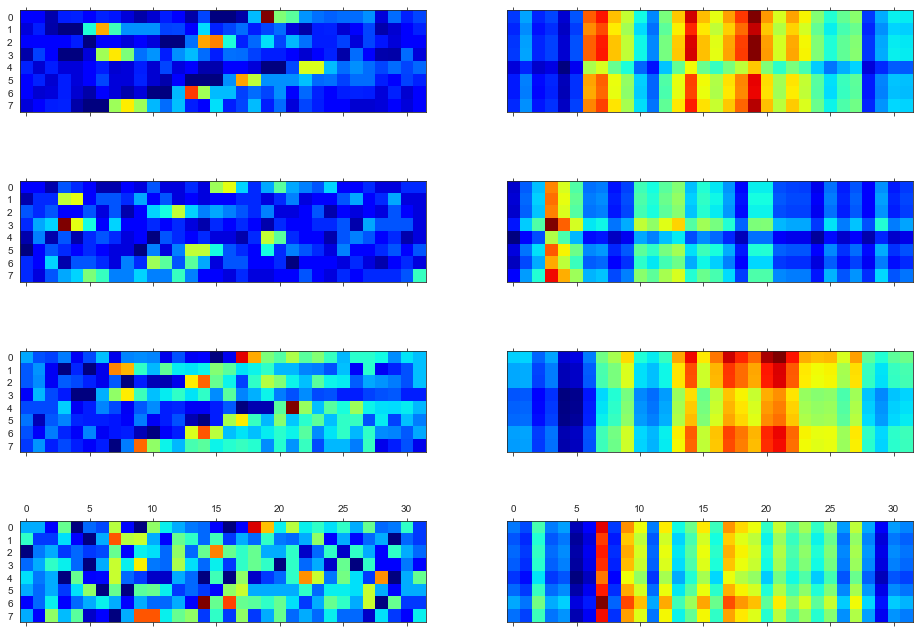

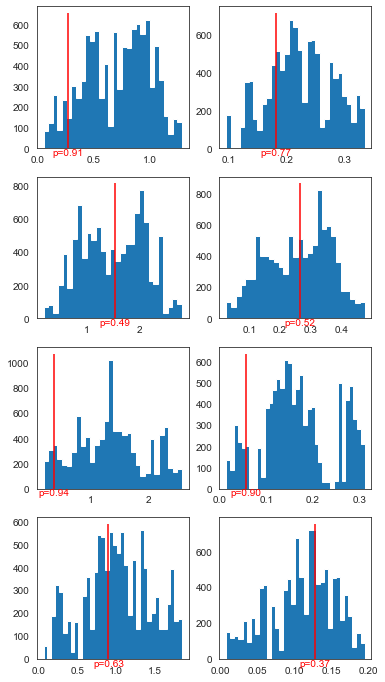

In [140]:
sample_rate = 25000
cells_to_plot = ['ch_71a', 'ch_71b', 'ch_72a', 'ch_72b']
num_cells = len(cells_to_plot)
min_duration = np.min(trigger_durations)
min_ticks = int(sample_rate * min_duration)
num_bins = 32
num_permuations = 1000
projection = np.exp(1j * angles)

fig = plt.figure(figsize=(6, 3 * num_cells))
axes = fig.subplots(num_cells, 2, subplot_kw={'polar': True}, squeeze=False,
                    sharex=True, sharey=False)

fig2 = plt.figure(figsize=(num_bins / 2, 3 * num_cells))
axes2 = fig2.subplots(num_cells, 2, squeeze=False, sharex=True, sharey=True)

fig3 = plt.figure(figsize=(6, 3 * num_cells))
axes3 = fig3.subplots(num_cells, 2, squeeze=False)

for cell_idx, cell_label in enumerate(cells_to_plot):
    spike_times_cell = spike_times_cells[cell_label]
    spike_sums = np.zeros((num_trials, num_directions, num_bins))
    for trial_idx, trigger_times_trial in enumerate(trigger_times):
        for direction_idx, trigger_time_direction in enumerate(trigger_times_trial):
            start = trigger_time_direction
            spike_times = get_interval(spike_times_cell, start, start + min_duration)
            spike_ticks = ((spike_times - start) * sample_rate).astype(int)
            spike_mask = np.zeros(min_ticks)
            spike_mask[spike_ticks] = 1
            spike_sum = skimage.measure.block_reduce(
                spike_mask, (min_ticks // num_bins,))[:num_bins]
            spike_sums[trial_idx, direction_idx] = spike_sum
        
        spike_sums[trial_idx] /= np.max(spike_sums[trial_idx])

        total_spike_counts = np.sum(spike_sums[trial_idx], -1)
        axes[cell_idx, 0].plot(angles, total_spike_counts, 'b', marker='o')
        axes[cell_idx, 0].plot((angles[-1], angles[0]), 
                               (total_spike_counts[-1], total_spike_counts[0]), 'b')        
        
        u, s, vh = np.linalg.svd(spike_sums[trial_idx].transpose())
        vv = vh[0]
        vv /= np.min(vv)
        axes[cell_idx, 1].plot(angles, vv, 'b', marker='o')
        axes[cell_idx, 1].plot([angles[-1], angles[0]], [vv[-1], vv[0]], 'b')
    
    mean_spike_counts = np.mean(np.sum(spike_sums, -1), 0)
    axes[cell_idx, 0].plot(angles, mean_spike_counts, 'k', marker='o')
    axes[cell_idx, 0].plot((angles[-1], angles[0]), 
                           (mean_spike_counts[-1], mean_spike_counts[0]), 'k')
    vectorsum = np.dot(projection, mean_spike_counts)
    dsi = np.abs(vectorsum)
    axes[cell_idx, 0].plot((0, np.angle(vectorsum)), (0, dsi), color='r')

    mat = np.mean(spike_sums, 0).transpose()
    u, s, vh = np.linalg.svd(mat)
    vv = vh[0]
    mat_reconstructed = s[0] * np.outer(u[:, 0], vv)
    axes2[cell_idx, 0].matshow(mat.transpose(), cmap='jet')
    axes2[cell_idx, 1].matshow(mat_reconstructed.transpose(), cmap='jet')
    vv_norm = vv / np.min(vv)
    snr_ = snr(spike_sums)
    axes[cell_idx, 1].plot(angles, vv_norm, 'k', marker='o', markerfacecolor='none')
    axes[cell_idx, 1].scatter(angles[snr_ > 0.6], vv_norm[snr_ > 0.6], 
                              marker='o', color='k')
    vectorsum1 = np.dot(projection, vv_norm)
    dsi1 = np.abs(vectorsum1)
    axes[cell_idx, 1].plot((0, np.angle(vectorsum1)), (0, dsi1), color='r')
    
    axes[cell_idx, 0].xaxis.set_ticklabels([])
    axes[cell_idx, 0].yaxis.set_ticklabels([])
    axes[cell_idx, 1].yaxis.set_ticklabels([])
    # axes[cell_idx, 0].set_ylim(0, 1)
    
    mean_spike_counts_copy = np.copy(mean_spike_counts)
    dsis_permuted = []
    for i in range(num_permuations):
        np.random.shuffle(mean_spike_counts_copy)
        dsi_permuted = np.abs(np.dot(projection, mean_spike_counts_copy))
        dsis_permuted.append(dsi_permuted)
    p = 1 - (percentileofscore(dsis_permuted, dsi) / 100)
    axes3[cell_idx, 0].hist(dsis_permuted, 'auto', histtype='stepfilled')
    axes3[cell_idx, 0].vlines(dsi, 0, axes3[cell_idx, 0].get_ylim()[1], 'r')
    axes3[cell_idx, 0].text(dsi, 0, "p={:.2f}".format(p), color='r',
                            horizontalalignment='center', verticalalignment='top')
    
    mat_copy = np.copy(np.mean(spike_sums, 0))
    dsis_permuted = []
    for i in range(num_permuations):
        np.random.shuffle(mat_copy)
        u, s, vh = np.linalg.svd(mat_copy.transpose())
        vv = vh[0]
        vv /= np.min(vv)
        dsi_permuted = np.abs(np.dot(projection, vv))
        dsis_permuted.append(dsi_permuted)
    p1 = 1 - (percentileofscore(dsis_permuted, dsi1) / 100)
    axes3[cell_idx, 1].hist(dsis_permuted, 'auto', histtype='stepfilled')
    axes3[cell_idx, 1].vlines(dsi1, 0, axes3[cell_idx, 1].get_ylim()[1], 'r')
    axes3[cell_idx, 1].text(dsi1, 0, "p={:.2f}".format(p1), color='r',
                            horizontalalignment='center', verticalalignment='top')
    
    # fig.subplots_adjust(wspace=0, hspace=0)
    